In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_CoM_acc
%store -r Y_motion_CoM_acc
print(X_motion_CoM_acc.shape)
print(Y_motion_CoM_acc.shape)

(9991, 28)
(9991, 2)


In [6]:
X_motion_CoM_acc[0]

array([0.0, 0.0, 0.0, 0.02913719938114322, 0.14719469368385946,
       0.022976086773515297, 0.003909692818189045, 0.008798872891276023,
       -0.014303295334153898, 0.22920227689822778, 0.18690779522150297,
       -0.4055380313041654, 0.2296633796873913, -0.2061291134676932,
       -0.4055005229248185, -0.2619380404423078, 0.13096712258597765,
       -0.40069670952693676, -0.25670755139947965, -0.152450443282568,
       -0.40044770287636394, False, True, True, False, 0.0, 0.0,
       -0.10000000149011612], dtype=object)

In [7]:
Y_motion_CoM_acc[0]

array([-0.0020009205030788735, -0.0232033010096917], dtype=object)

# Multivariate Linear Regression (CoM Prediction)

In [8]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [9]:
idx_fr_rl_swinging = np.where(X_motion_CoM_acc[:, 22] == 1)[0]
X_motion_CoM_acc_FR_RL = X_motion_CoM_acc[idx_fr_rl_swinging]
Y_motion_CoM_acc_FR_RL = Y_motion_CoM_acc[idx_fr_rl_swinging]
print(X_motion_CoM_acc_FR_RL.shape)
print(Y_motion_CoM_acc_FR_RL.shape)

(4992, 28)
(4992, 2)


## Predict CoM (x) movement

In [10]:
X_motion_CoM_acc_FR_RL[0, :]

array([0.0, 0.0, 0.0, 0.02913719938114322, 0.14719469368385946,
       0.022976086773515297, 0.003909692818189045, 0.008798872891276023,
       -0.014303295334153898, 0.22920227689822778, 0.18690779522150297,
       -0.4055380313041654, 0.2296633796873913, -0.2061291134676932,
       -0.4055005229248185, -0.2619380404423078, 0.13096712258597765,
       -0.40069670952693676, -0.25670755139947965, -0.152450443282568,
       -0.40044770287636394, False, True, True, False, 0.0, 0.0,
       -0.10000000149011612], dtype=object)

In [11]:
Y_motion_CoM_acc_FR_RL[0, :]

array([-0.0020009205030788735, -0.0232033010096917], dtype=object)

### Linear Regression

In [29]:
# Input
X = np.hstack((X_motion_CoM_acc_FR_RL[:, :3], # previous motion command
               X_motion_CoM_acc_FR_RL[:, -3:], # commanded motion command
               X_motion_CoM_acc_FR_RL[:, 9:11], # FL (x,y) position
               X_motion_CoM_acc_FR_RL[:, 12:14], # FR (x,y) position
               X_motion_CoM_acc_FR_RL[:, 15:17], # RL (x,y) position
               X_motion_CoM_acc_FR_RL[:, 18:20])) # RR (x,y) position

# Labels
Y = np.array([Y_motion_CoM_acc_FR_RL[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True)

# Create the model
model_fr_com_x = LinearRegression()

# Fit the model
model_fr_com_x.fit(X_train, Y_train)

# Predict
predictions = model_fr_com_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9053808381225023
RMSE:  0.011924507388290666
The lowest error is:  2.1433158896549953e-05
The highest error is:  0.06127129283293038
The avg. error is:  0.008116932208851266


In [30]:
model_fr_com_x.coef_

array([[-0.00785711, -0.09023743,  0.08701676,  0.06037753,  0.00483609,
         0.05642675,  0.08561308,  0.36527627,  0.41892593,  0.1820427 ,
        -0.2085264 , -0.05150759,  1.05555253,  0.39668034]])

In [31]:
model_fr_com_x.intercept_

array([0.13359696])

Text(0, 0.5, 'Predictions')

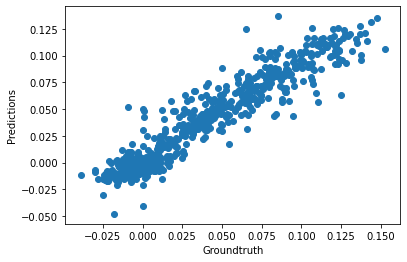

In [32]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [33]:
#%store model_fr_com_x

In [34]:
#for idx, prediction in enumerate(predictions):
#    print(f'Command: {X_test[idx, :3]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [35]:
# Save model
#joblib.dump(model_fr_com_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fr_com_x.sav")

## Predict CoM -> y

### Linear Regression

In [45]:
# Input
X = np.hstack((X_motion_CoM_acc_FR_RL[:, :3], # previous motion command
               X_motion_CoM_acc_FR_RL[:, -3:], # commanded motion command
               X_motion_CoM_acc_FR_RL[:, 9:11], # FL (x,y) position
               X_motion_CoM_acc_FR_RL[:, 12:14], # FR (x,y) position
               X_motion_CoM_acc_FR_RL[:, 15:17], # RL (x,y) position
               X_motion_CoM_acc_FR_RL[:, 18:20])) # RR (x,y) position

# Labels
Y = np.array([Y_motion_CoM_acc_FR_RL[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True)

# Create the model
model_fr_com_y = LinearRegression()

# Fit the model
model_fr_com_y.fit(X_train, Y_train)

# Predict
predictions = model_fr_com_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.8475834347598437
RMSE:  0.010329827745784623
The lowest error is:  7.225818875501722e-06
The highest error is:  0.07040893771107576
The avg. error is:  0.00683454157473402


In [46]:
model_fr_com_y.coef_

array([[-0.00539496,  0.14468128,  0.03597647,  0.01815237,  0.05197553,
         0.04127224, -0.0077449 ,  0.28577389, -0.20428162,  0.56630772,
        -0.02588052, -0.05371182, -0.23978806, -0.39057983]])

In [47]:
model_fr_com_y.intercept_

array([-0.02957964])

Text(0, 0.5, 'Predictions')

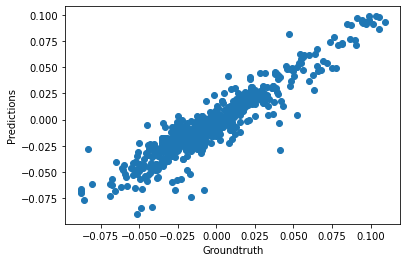

In [48]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [36]:
#%store model_fr_com_y

In [37]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [38]:
# Save model
#joblib.dump(model_fr_com_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fr_com_y.sav")